In [24]:
import os
import subprocess
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
os.system(f"openstudio workflow/run_analysis.rb -y project_national/national_baseline.yml -n 1 -k")

0

In [6]:
building_unit_type_to_resstock_category = {"2": 'Multi-Family with 2 - 4 Units', "3_4": 'Multi-Family with 2 - 4 Units', "5_9": 'Multi-Family with 5+ Units', "10_19": 'Multi-Family with 5+ Units', "20_49": 'Multi-Family with 5+ Units', "50_plus": 'Multi-Family with 5+ Units', "SFA": 'Single-Family Attached', "SFD": 'Single-Family Detached' }

In [8]:
for (unit_type, resstock_category) in building_unit_type_to_resstock_category.items():
    print(unit_type)
    # os.system(f"openstudio workflow/run_analysis.rb -y project_minneapolis/minneapolis_upgrades.yml -t {unit_type} -n 1 -k")
    result = subprocess.run(f"openstudio {join('workflow','run_analysis.rb')} -y {join('project_minneapolis','minneapolis_baseline.yml')} -t {unit_type} -n 1 -k", shell=True, capture_output=True, text=True)

    # Print the output and error messages
    print("Output:\n", result.stdout)
    print("Error:\n", result.stderr)
    print("\n")

2
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_2_unit_residence' already exists.

Error:
 


3_4
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_3_4_unit_residence' already exists.

Error:
 


5_9
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_5_9_unit_residence' already exists.

Error:
 


10_19
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_10_19_unit_residence' already exists.

Error:
 


20_49
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_20_49_unit_residence' already exists.

Error:
 


50_plus
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_50_plus_unit_residence' already exists.

Error:
 


SFA


In [42]:
season_to_color = ["blue", "green", "orange", "maroon"]
label_to_column = {"elec": "Fuel Use: Electricity: Total", "temp": "Weather: Drybulb Temperature", "time": "Time"}

In [66]:
def create_graph(graph_type, x_value, y_value, selected_day):

    # figs, axes = plt.subplots(1,len(building_unit_type_to_resstock_category))
    for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
        fig, ax = plt.subplots()
        filepath = join(f"minneapolis_baseline_single_{unit_type}_unit_residence", 'run1','run', 'results_timeseries.csv')
        timeseries_data = pd.read_csv(filepath, low_memory=False, usecols=["Time", "Fuel Use: Electricity: Total", "Weather: Drybulb Temperature"])
        
        # Assuming 'Time' column is of datetime type, if not convert it
        timeseries_data['Time'] = pd.to_datetime(timeseries_data['Time'])

        # Define seasons
        def get_season(date):
            if date.month in [12, 1, 2]:
                return 'Winter'
            elif date.month in [3, 4, 5]:
                return 'Spring'
            elif date.month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'

        # Create a 'Season' column
        timeseries_data['Season'] = timeseries_data['Time'].apply(get_season)

        # Extract just the date from 'Time'
        timeseries_data['Date'] = timeseries_data['Time'].dt.date

        # Group by 'Date' and 'Season' and calculate the mean temperature for each day
        daily_avg_temp = timeseries_data.groupby(['Date', 'Season'])['Weather: Drybulb Temperature'].mean().reset_index()
        daily_peak_electricity_use = timeseries_data.groupby(['Date', 'Season'])["Fuel Use: Electricity: Total"].max().reset_index()

        # Function to find the representative day for each season
        def find_representative_day(season):
            if selected_day == "median":
                season_data = daily_avg_temp[daily_avg_temp['Season'] == season]
                season_mean_temp = season_data['Weather: Drybulb Temperature'].mean()
                representative_day = season_data.iloc[(season_data['Weather: Drybulb Temperature'] - season_mean_temp).abs().argsort()].iloc[0]
                # print(representative_day['Date'])
                return representative_day['Date']
            if selected_day == "peak_electricity":
                season_data = daily_peak_electricity_use[daily_peak_electricity_use['Season'] == season]
                season_peak_electricity_use = season_data["Fuel Use: Electricity: Total"].max()
                representative_day = season_data[(season_data["Fuel Use: Electricity: Total"] == season_peak_electricity_use)].iloc[0]
                # print(representative_day['Date'])
                return representative_day['Date']

        # Find the representative day for each season
        representative_days = {season: find_representative_day(season) for season in ['Winter', 'Spring', 'Summer', 'Fall']}

        # Filter the original dataframe for the 24-hour periods of the representative days
        representative_days_df = pd.DataFrame()
        for i, (season, representative_day) in enumerate(representative_days.items()):
            representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
            # representative_days_df = pd.concat([representative_days_df, representative_day_data])
            # axes[i//2][i % 2].set_title(season)
            if graph_type == "scatter":
                ax.scatter(x=representative_day_data[label_to_column[x_value]], y=representative_day_data[label_to_column[y_value]], c=season_to_color[i], label=season)
            if graph_type == "line":
                ax.plot(representative_day_data[label_to_column[x_value]].dt.hour, representative_day_data[label_to_column[y_value]], linestyle='-', c=season_to_color[i], label=season)
            # axes[i//2][i % 2].scatter(x=representative_day_data["Weather: Drybulb Temperature"], y=representative_day_data["Fuel Use: Electricity: Total"], c=season_to_color[i])
        ax.set_title(f"{unit_type} Unit ({resstock_category})")
        ax.set_xlabel(label_to_column[x_value])
        ax.set_ylabel(label_to_column[y_value])
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        fig.savefig(join(f"minneapolis_baseline_single_{unit_type}_unit_residence", f"{x_value}_{y_value}_{selected_day}_{graph_type}.svg"))

2007-02-01
2007-05-15
2007-08-13
2007-09-07
2007-02-01
2007-05-15
2007-08-13
2007-09-07
2007-02-01
2007-05-15
2007-08-13
2007-09-09
2007-01-09
2007-03-09
2007-08-13
2007-11-17
2007-12-16
2007-03-04
2007-06-10
2007-11-05
2007-02-12
2007-03-04
2007-06-10
2007-11-05
2007-12-08
2007-03-11
2007-06-16
2007-10-28
2007-12-13
2007-04-03
2007-07-31
2007-11-20


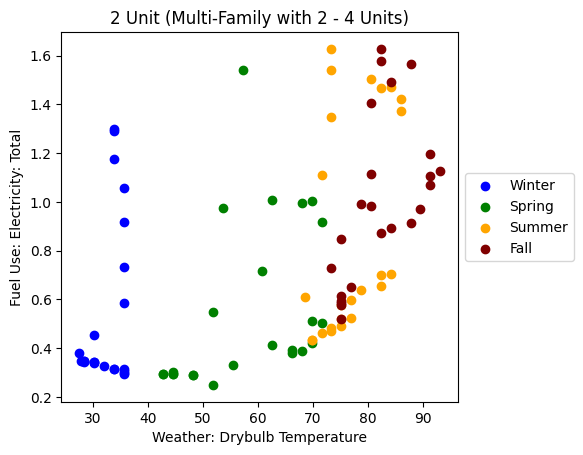

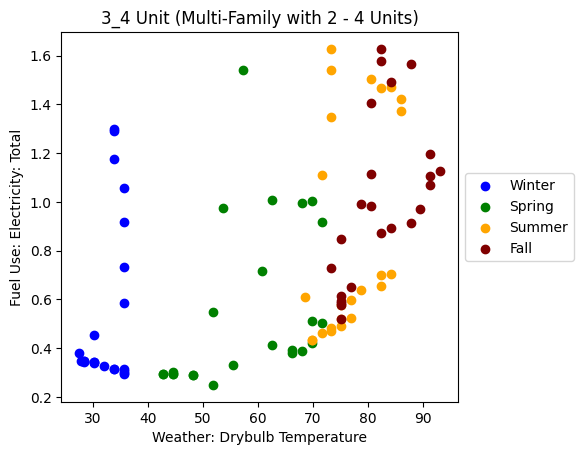

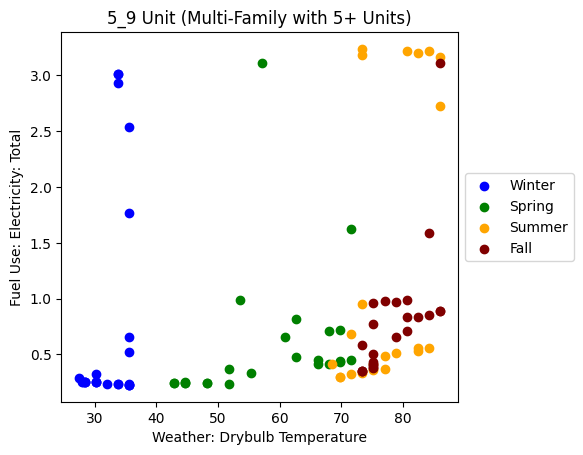

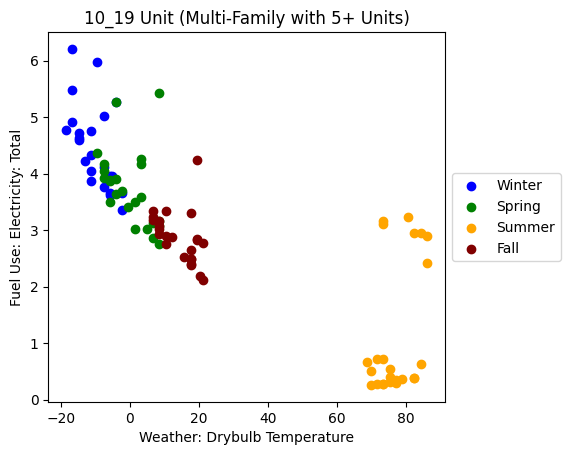

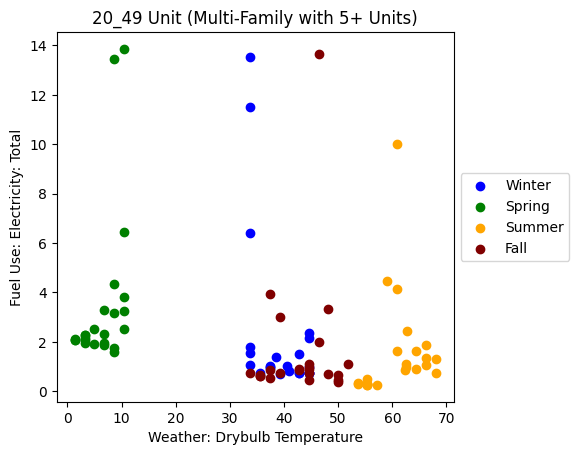

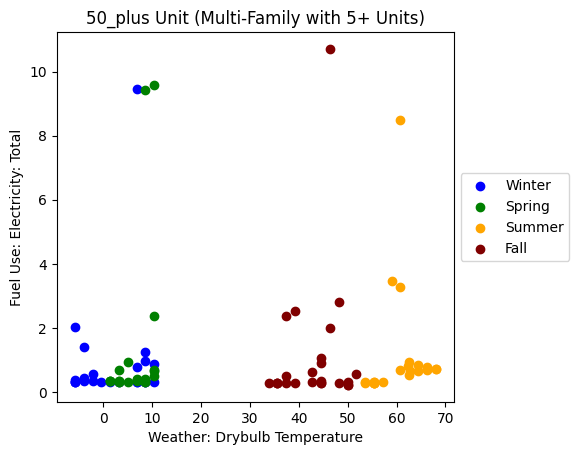

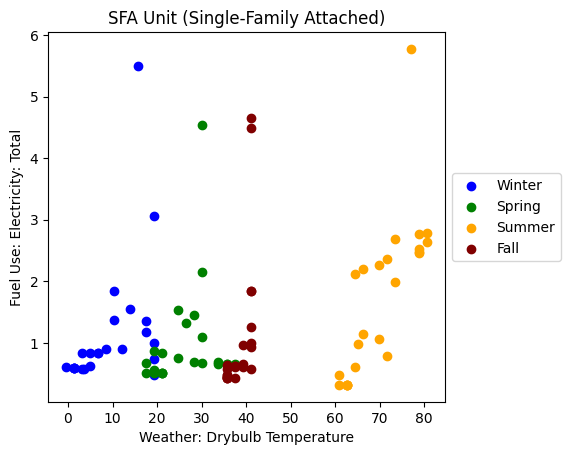

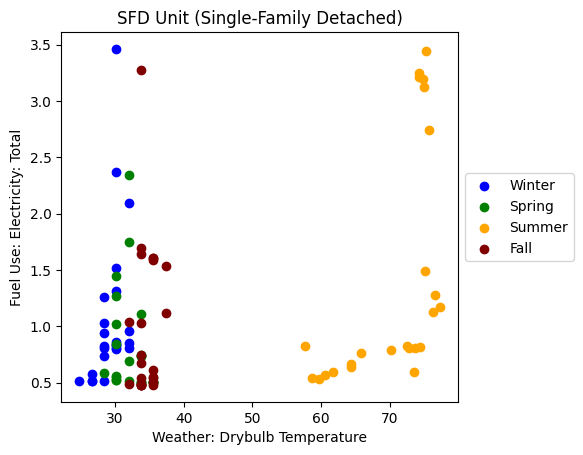

In [63]:
create_graph("scatter", "temp", "elec", "peak_electricity")

2007-02-01
2007-05-15
2007-08-13
2007-09-07
2007-02-01
2007-05-15
2007-08-13
2007-09-07
2007-02-01
2007-05-15
2007-08-13
2007-09-09
2007-01-09
2007-03-09
2007-08-13
2007-11-17
2007-12-16
2007-03-04
2007-06-10
2007-11-05
2007-02-12
2007-03-04
2007-06-10
2007-11-05
2007-12-08
2007-03-11
2007-06-16
2007-10-28
2007-12-13
2007-04-03
2007-07-31
2007-11-20


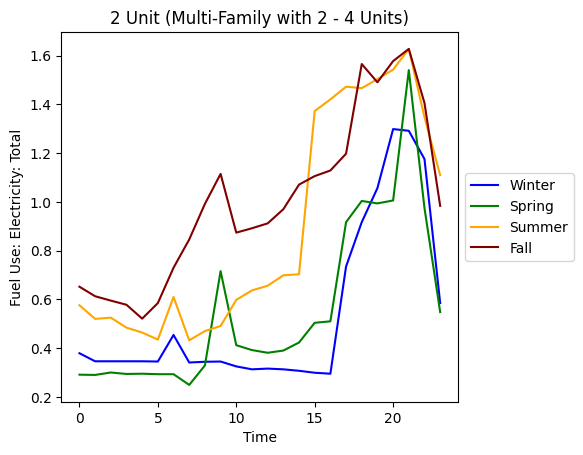

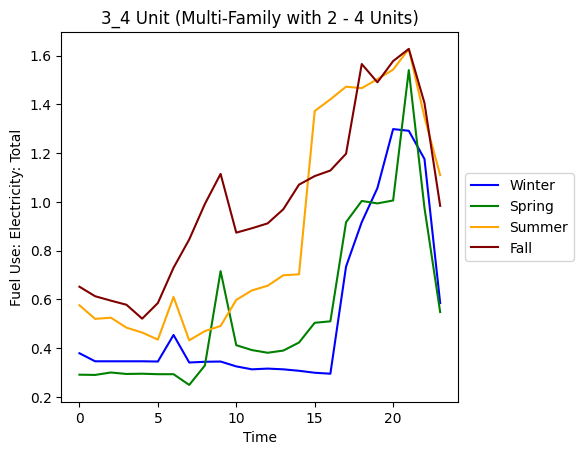

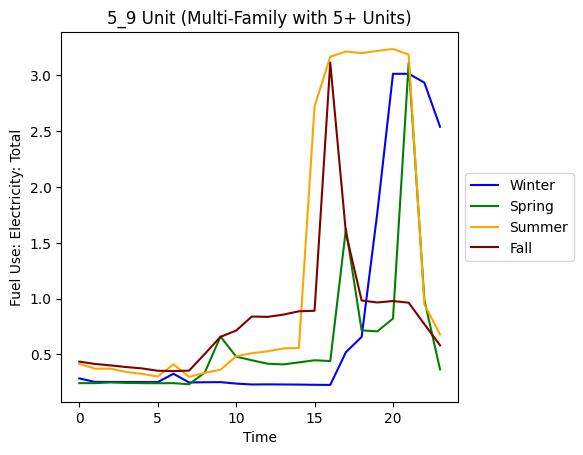

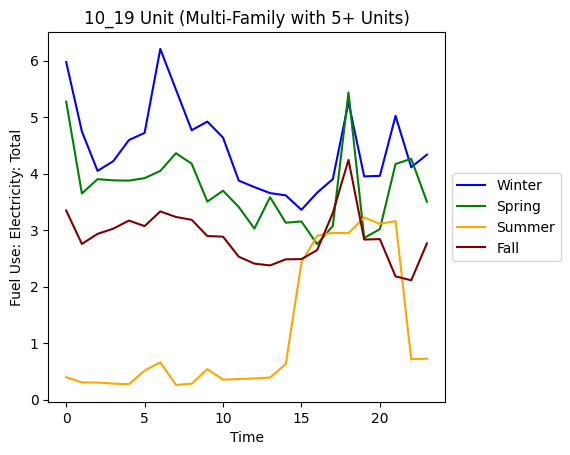

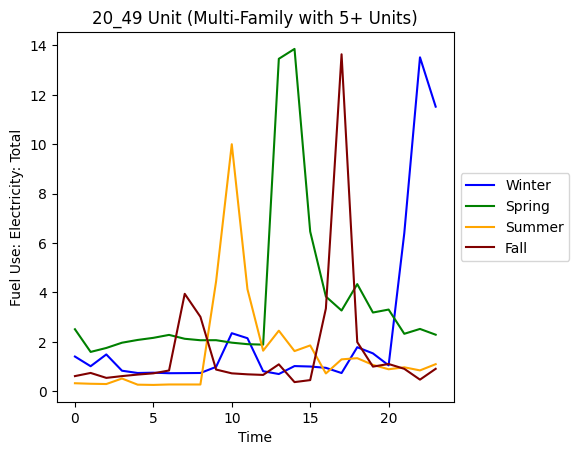

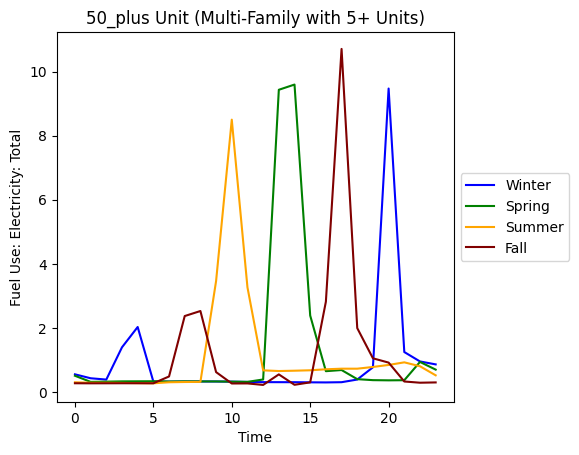

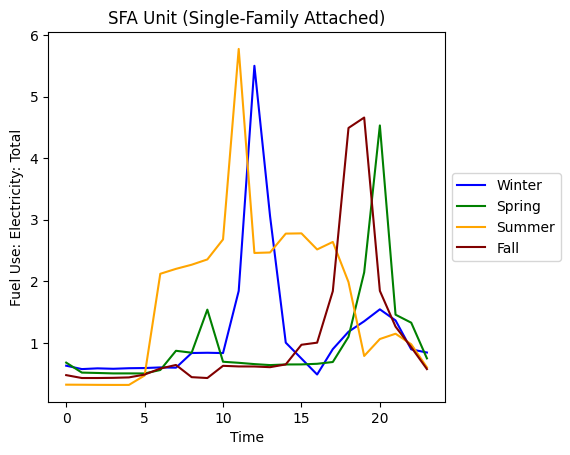

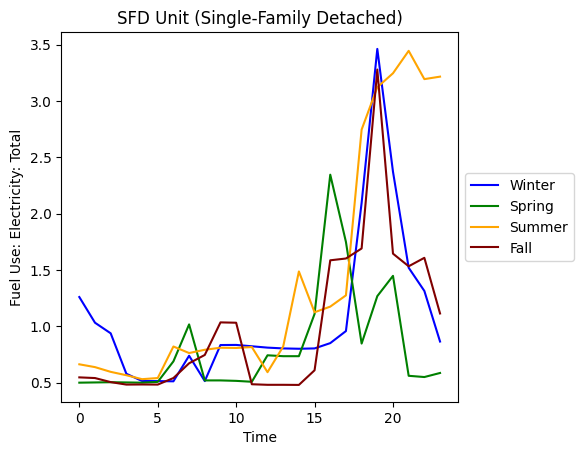

In [62]:
create_graph("line", "time", "elec", "peak_electricity")

In [65]:
for (unit_type, resstock_category) in building_unit_type_to_resstock_category.items():
    print(unit_type)
    # os.system(f"openstudio workflow/run_analysis.rb -y project_minneapolis/minneapolis_upgrades.yml -t {unit_type} -n 1 -k")
    result = subprocess.run(f"openstudio {join('workflow','run_analysis.rb')} -y {join('project_minneapolis','minneapolis_upgrades.yml')} -t {unit_type} -n 1 -k", shell=True, capture_output=True, text=True)

    # Print the output and error messages
    print("Output:\n", result.stdout)
    print("Error:\n", result.stderr)
    print("\n")

2
Output:
 YML: project_minneapolis\minneapolis_upgrades.yml
../resources/single_2_unit_buildstock.csv
[Parallel(n_jobs=1)]: 1 / 5 | elapsed:    42.2s
[Parallel(n_jobs=1)]: 2 / 5 | elapsed:   1.5min
[Parallel(n_jobs=1)]: 3 / 5 | elapsed:   2.4min
[Parallel(n_jobs=1)]: 4 / 5 | elapsed:   2.8min
[Parallel(n_jobs=1)]: 5 / 5 | elapsed:   3.7min

Wrote: c:/Users/Arnav/Documents/Research/Trane Technologies/resstock-3.2.0_repo/resstock-3.2.0/minneapolis_upgrades_single_2_unit_residence/results-Baseline.csv
Wrote: c:/Users/Arnav/Documents/Research/Trane Technologies/resstock-3.2.0_repo/resstock-3.2.0/minneapolis_upgrades_single_2_unit_residence/results-ASHP.csv
Wrote: c:/Users/Arnav/Documents/Research/Trane Technologies/resstock-3.2.0_repo/resstock-3.2.0/minneapolis_upgrades_single_2_unit_residence/results-MSHP.csv
Wrote: c:/Users/Arnav/Documents/Research/Trane Technologies/resstock-3.2.0_repo/resstock-3.2.0/minneapolis_upgrades_single_2_unit_residence/results-MSHPwoDucts.csv
Wrote: c:/Users/A

In [85]:
for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
    for j in range(5):
        filepath = join(f"minneapolis_upgrades_single_{unit_type}_unit_residence", f'run{j+1}','run', 'results_timeseries.csv')
        try:
            timeseries_data = pd.read_csv(filepath, low_memory=False)
            if (timeseries_data.iloc[0]["Time"] is np.NaN):
                timeseries_data = timeseries_data.drop(timeseries_data.index[0])
                timeseries_data.to_csv(filepath)
        except Exception as e:
            pass
        

In [89]:
upgrade_to_color = ["gray", "brown", "pink", "olive", "cyan"]# {"winter": "blue", "spring": , "summer": , "fall": }
upgrade_to_shape = ["o", "X", "^", "v", "D"]
upgrade_to_label = ["Baseline", "ASHP", "MSHP", "MSHPwoDucts", "GSHP"]

In [108]:
def create_upgrade_graph(graph_type, x_value, y_value, selected_day="peak_electricity"):
    # figs, axes = plt.subplots(1,len(building_unit_type_to_resstock_category))
    for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
        # if i != 0:
        #     continue
        fig, ax = plt.subplots(figsize=(7, 5))
        for j in range(5):
            filepath = join(f"minneapolis_upgrades_single_{unit_type}_unit_residence", f'run{j+1}','run', 'results_timeseries.csv')
            try:
                timeseries_data = pd.read_csv(filepath, low_memory=False, usecols=["Time", "Fuel Use: Electricity: Total", "Weather: Drybulb Temperature"])
            except Exception as e:
                continue
            # print(timeseries_data)
            # Assuming 'Time' column is of datetime type, if not convert it
            timeseries_data['Time'] = pd.to_datetime(timeseries_data['Time'])

            # Define seasons
            def get_season(date):
                if date.month in [12, 1, 2]:
                    return 'Winter'
                elif date.month in [3, 4, 5]:
                    return 'Spring'
                elif date.month in [6, 7, 8]:
                    return 'Summer'
                else:
                    return 'Fall'

            # Create a 'Season' column
            timeseries_data['Season'] = timeseries_data['Time'].apply(get_season)

            # Extract just the date from 'Time'
            timeseries_data['Date'] = timeseries_data['Time'].dt.date

            # Group by 'Date' and 'Season' and calculate the mean temperature for each day
            daily_avg_temp = timeseries_data.groupby(['Date', 'Season'])['Weather: Drybulb Temperature'].mean().reset_index()
            daily_peak_electricity_use = timeseries_data.groupby(['Date', 'Season'])["Fuel Use: Electricity: Total"].max().reset_index()

            # Function to find the representative day for each season
            def find_representative_day(season):
                if selected_day == "median":
                    season_data = daily_avg_temp[daily_avg_temp['Season'] == season]
                    season_mean_temp = season_data['Weather: Drybulb Temperature'].mean()
                    representative_day = season_data.iloc[(season_data['Weather: Drybulb Temperature'] - season_mean_temp).abs().argsort()].iloc[0]
                    # print(representative_day['Date'])
                    return representative_day['Date']
                if selected_day == "peak_electricity":
                    season_data = daily_peak_electricity_use[daily_peak_electricity_use['Season'] == season]
                    season_peak_electricity_use = season_data["Fuel Use: Electricity: Total"].max()
                    representative_day = season_data[(season_data["Fuel Use: Electricity: Total"] == season_peak_electricity_use)].iloc[0]
                    # print(representative_day['Date'])
                    return representative_day['Date']

            # Find the representative day for each season
            representative_days = {season: find_representative_day(season) for season in ['Winter', 'Spring', 'Summer', 'Fall']}
            # print(representative_days)

            # Filter the original dataframe for the 24-hour periods of the representative days
            representative_days_df = pd.DataFrame()
            for i, (season, representative_day) in enumerate(representative_days.items()):
                if season != "Summer":
                    continue
                representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
                # representative_days_df = pd.concat([representative_days_df, representative_day_data])
                # axes[i//2][i % 2].set_title(season)
                if graph_type == "scatter":
                    ax.scatter(x=representative_day_data[label_to_column[x_value]], y=representative_day_data[label_to_column[y_value]], c=upgrade_to_color[j], label=upgrade_to_label[j], marker=upgrade_to_shape[j])
                if graph_type == "line":
                    ax.plot(representative_day_data[label_to_column[x_value]].dt.hour, representative_day_data[label_to_column[y_value]], linestyle='-', c=upgrade_to_color[j], label=upgrade_to_label[j], marker=upgrade_to_shape[j])
                # axes[i//2][i % 2].scatter(x=representative_day_data["Weather: Drybulb Temperature"], y=representative_day_data["Fuel Use: Electricity: Total"], c=upgrade_to_color[j])
            ax.set_title(f"{unit_type} Unit ({resstock_category})")
            ax.set_xlabel(label_to_column[x_value])
            ax.set_ylabel(label_to_column[y_value])
            # Shrink current axis by 20%
            # box = ax.get_position()
            # ax.set_position([box.x0, box.y0, box.width, box.height])
            

            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        fig.savefig(join(f"minneapolis_upgrades_single_{unit_type}_unit_residence", f"{x_value}_{y_value}_{selected_day}_{graph_type}.svg"), bbox_inches='tight')


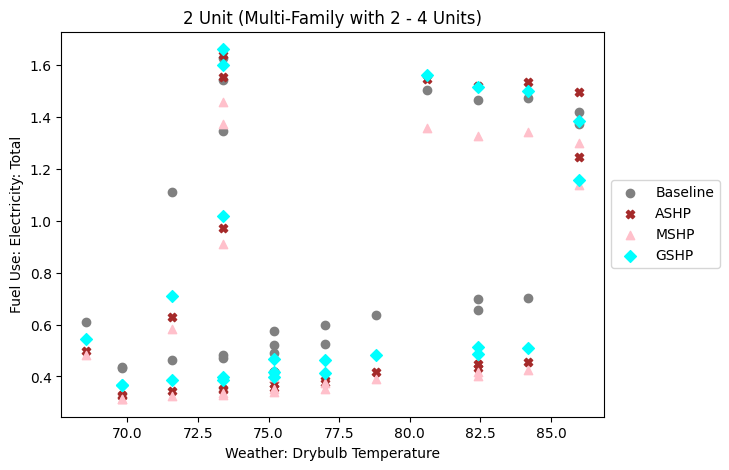

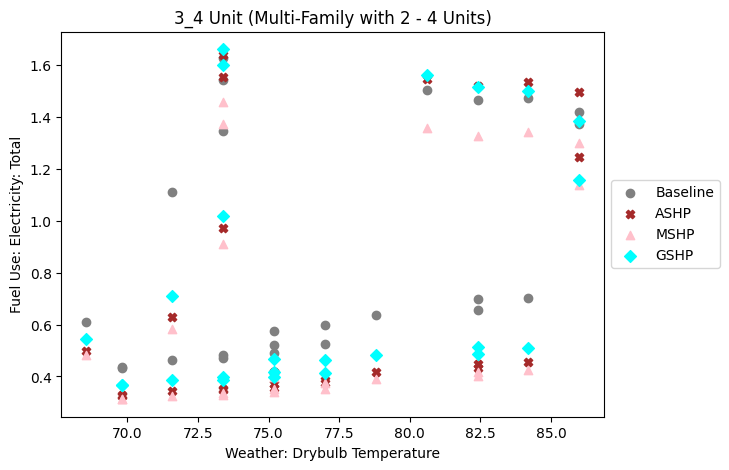

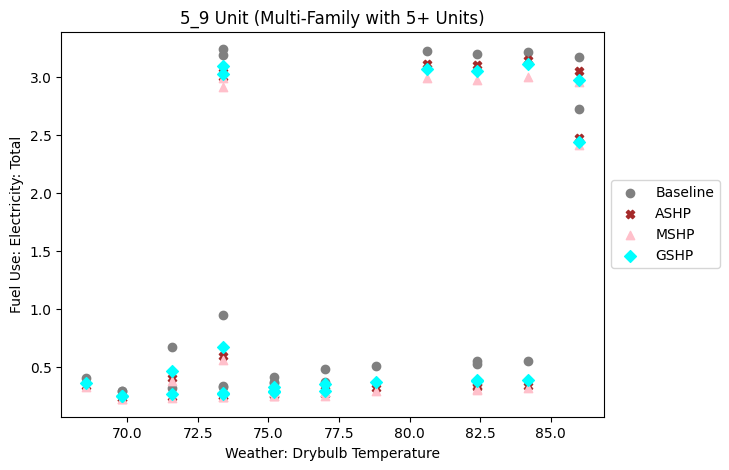

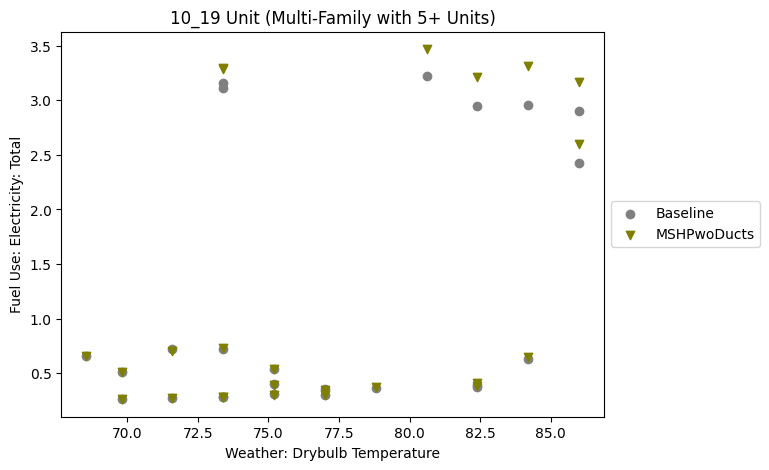

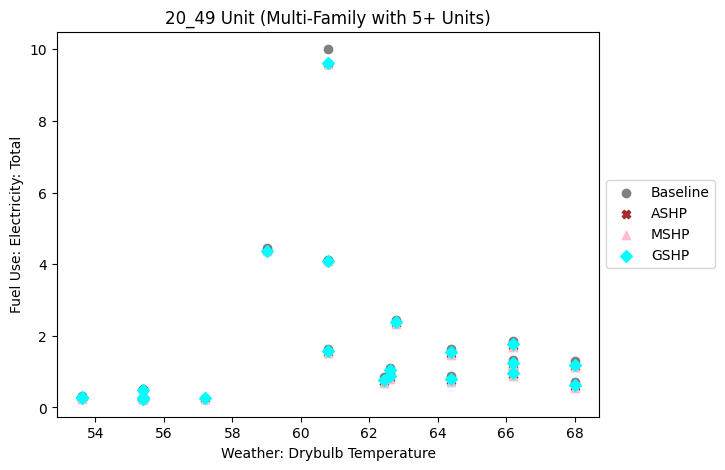

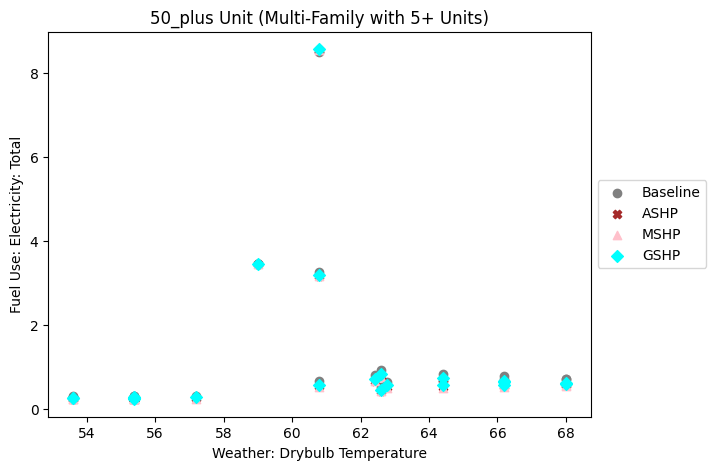

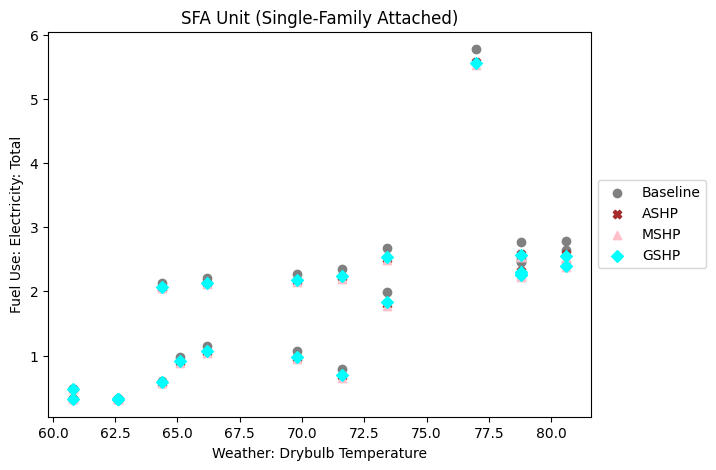

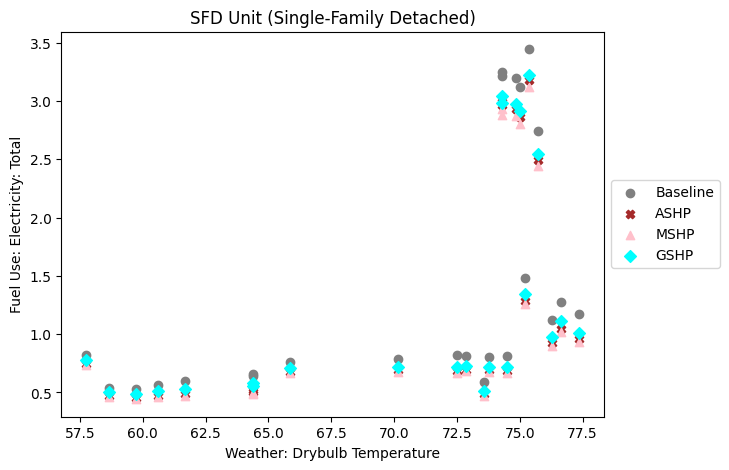

In [109]:
create_upgrade_graph("scatter", "temp", "elec", "peak_electricity")

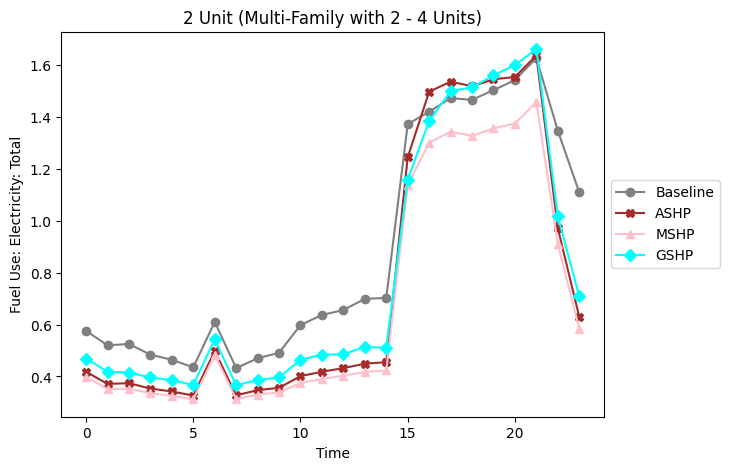

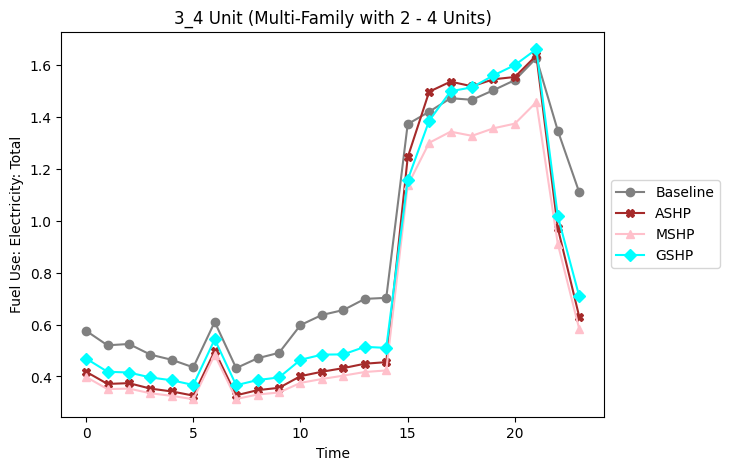

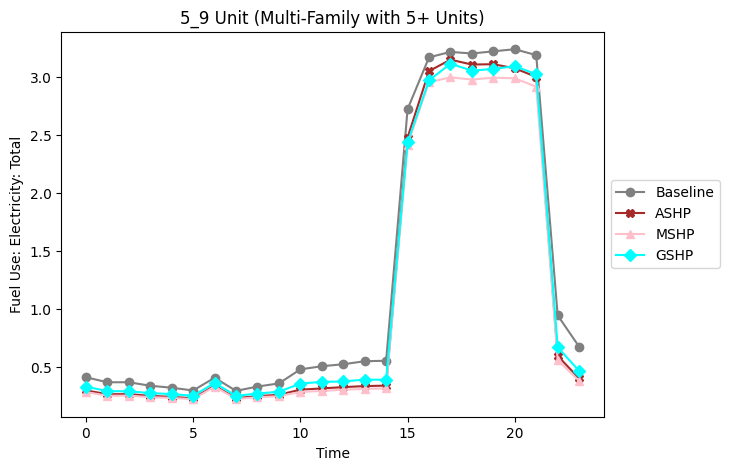

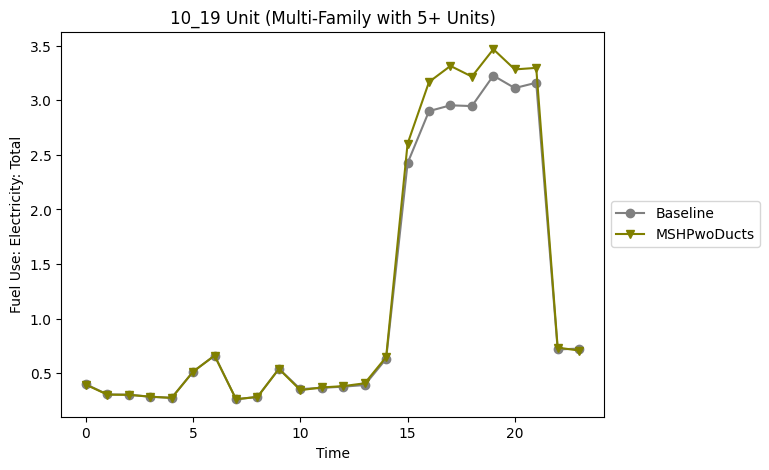

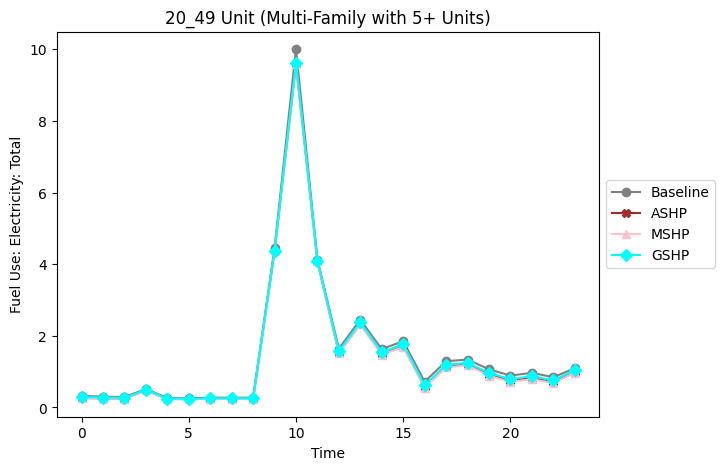

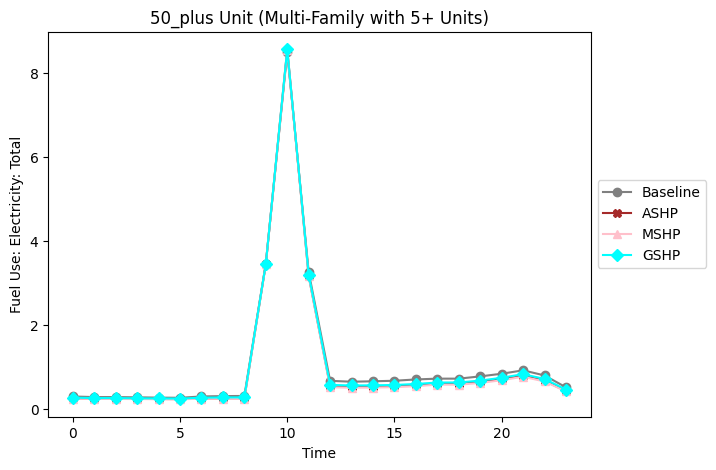

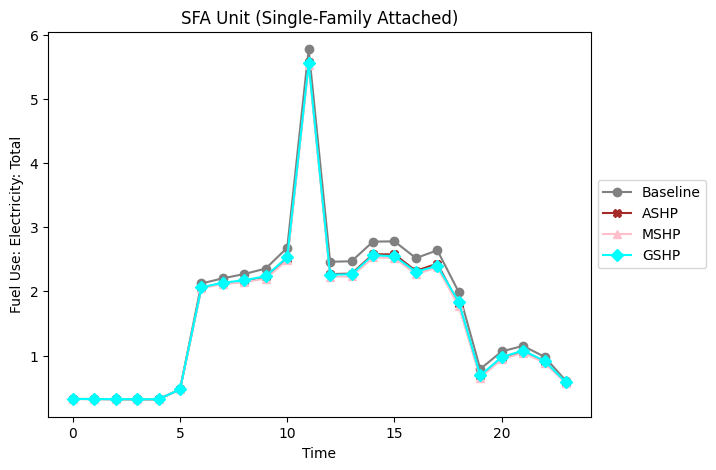

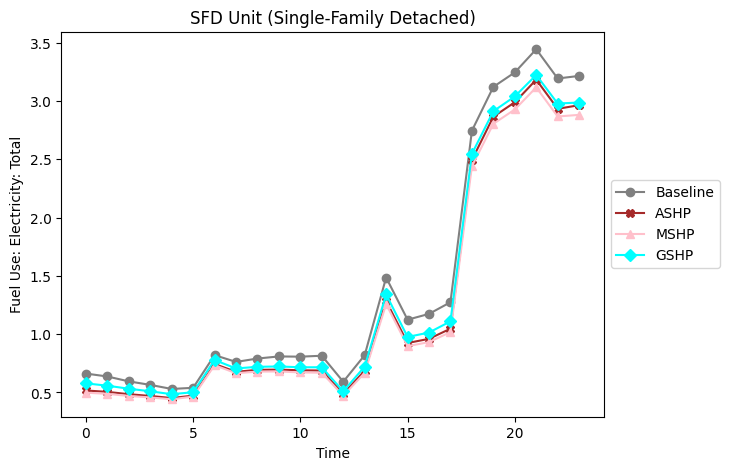

In [110]:
create_upgrade_graph("line", "time", "elec", "peak_electricity")

105